<a href="https://colab.research.google.com/github/dyutivartak/ML-Projects/blob/main/Attendance_Management_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install face_recognition

In [2]:
!mkdir known
!mkdir unknown

In [4]:
import os
import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
import random
from matplotlib import pyplot as plt
import uuid
import csv
import datetime
import face_recognition
from google.colab.patches import cv2_imshow
import time
import shutil

In [5]:
def face(image1,name="",k=True):
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  image = cv2.imread(image1)
  faces = face_cascade.detectMultiScale(image, 1.1, 7)
  for (x, y, w, h) in faces:
      cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
      faces = image[y:y + h, x:x + w]
      cv2_imshow(faces)
      cv2.imwrite(os.path.join("/content/new", '{}.jpg'.format(uuid.uuid1())), faces)
      if k:
        cv2.imwrite(f'/content/known/{name}', faces)
      else:
        cv2.imwrite('/content/unknown/photo.jpg', faces)
  return faces

In [6]:
def append_to_csv(filename, name):
    index = name.find('_')
    if index != -1:
      extracted_string = name[:index]
    else:
      extracted_string = name
    name=extracted_string
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d")
    data = [name, timestamp]
    with open(filename, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(data)

In [7]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      await new Promise((resolve) => capture.onclick = resolve);
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [8]:
name=input("Name of the person: ")
name=name+".jpg"
image_file = take_photo(name)

Name of the person: D


<IPython.core.display.Javascript object>

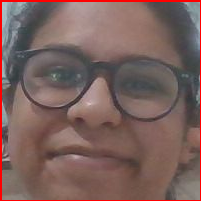

In [9]:
validation_img = face(f"/content/{name}",name)

In [10]:
image_file = take_photo()

<IPython.core.display.Javascript object>

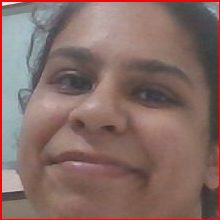

In [11]:
validation_img = face("/content/photo.jpg","",False)

Processing photo.jpg
[0.34984534]
[True]


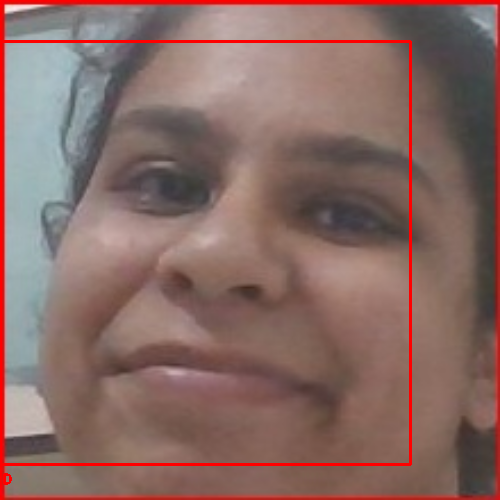

D
Time taken: 0.5031871795654297 seconds


In [13]:
!rm -rf known/.ipynb_checkpoints
!rm -rf unknown/.ipynb_checkpoints
start_time = time.time()
def read_img(path):
  img=cv2.imread(path)
  (h,w)=img.shape[:2]
  width=500
  ratio=width/float(w)
  height=int(h*ratio)
  return cv2.resize(img,(width,height))

known_encodings =[]
known_names=[]
known_dir="/content/known"
unknown_dir="/content/unknown"

for file in os.listdir(known_dir):
  if (known_dir+'/'+file)!="known/.ipynb_checkpoints":
    img=read_img(known_dir+'/'+file)
    loc=face_recognition.face_locations(img,number_of_times_to_upsample=1, model='cnn')
    if face_recognition.face_encodings(img,loc,num_jitters=10, model='large')!=[]:
      img_enc=face_recognition.face_encodings(img,loc,num_jitters=10, model='large')[0]
      known_encodings.append(img_enc)
      known_names.append(file.split(".")[0])
for file in os.listdir(unknown_dir):
  if (unknown_dir+'/'+file)!="unknown/.ipynb_checkpoints":
    print("Processing",file)
    img=read_img(unknown_dir+"/"+file)
    loc=face_recognition.face_locations(img,number_of_times_to_upsample=1, model='cnn')
    if face_recognition.face_encodings(img,loc,num_jitters=10, model='large')!=[]:
      img_enc=face_recognition.face_encodings(img,loc,num_jitters=1, model='large')[0] 
  similarity_scores = face_recognition.face_distance(known_encodings,img_enc)
  print(similarity_scores)
  results =face_recognition.compare_faces(known_encodings,img_enc,tolerance=0.55)

  print(face_recognition.compare_faces(known_encodings,img_enc,tolerance=0.55))
  for i in range(len(results)):
    if results[i]:
      name=known_names[i]
      index = name.find('_')
      if index != -1:
        extracted_string = name[:index]
      else:
        extracted_string = name
      name=extracted_string
      if face_recognition.face_encodings(img,num_jitters=10, model='large')!=[]:
        (top,right,bottom,left)=face_recognition.face_locations(img,number_of_times_to_upsample=1, model='cnn')[0]
        cv2.rectangle(img,(left,top),(right,bottom),(0,0,255),2)
        cv2.putText(img,name,(left+2,bottom+20),cv2.FONT_HERSHEY_PLAIN,1,(0,0,255),2)
        cv2_imshow(img)
        print(name)
        append_to_csv("Attendance",name)
end_time = time.time()
print('Time taken: {} seconds'.format(end_time - start_time))

In [14]:
os.remove("/content/photo.jpg")
os.remove("/content/unknown/photo.jpg")

In [15]:
!rm -rf known/.ipynb_checkpoints
!rm -rf unknown/.ipynb_checkpoints